In [346]:
import pandas as pd
import os
from sklearn.neighbors import NearestNeighbors
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.express as px
import scipy.stats as st
import plotly.graph_objects as go

# Parallel question Maxime

In [347]:
folder_processed_data_path = './data/processed_data/'

# Import movie metadata
movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_df.csv'))
movie_df.set_index(['wiki_ID'], inplace=True)
display(movie_df)

# Import character metadata
name_by_movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_pvalue_10_5_df.csv'))
name_by_movie_df.set_index(['wiki_ID'], inplace=True)
display(name_by_movie_df)

# Dataset containing movie genre
movie_genres_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_genres_df.csv'))
movie_genres_df.set_index(['wiki_ID'], inplace=True)
display(movie_genres_df)

,mov_name,year,month,revenue,numVotes,averageRating
wiki_ID,,,,,,
975900,Ghosts of Mars,2001,8.0,14010832.0,56880,4.9
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,2.0,NaN,69,6.0
28463795,Brun bitter,1988,NaN,NaN,40,5.6
9363483,White Of The Eye,1987,NaN,NaN,2891,6.1
261236,A Woman in Flames,1983,NaN,NaN,623,5.9
...,...,...,...,...,...,...
35228177,Mermaids: The Body Found,2011,3.0,NaN,1711,4.6
34980460,Knuckle,2011,1.0,NaN,3192,6.8
9971909,Another Nice Mess,1972,9.0,NaN,111,5.8


,char_words,order,gender,t_stat,p_value,slope_change
wiki_ID,,,,,,
3217,Gold,6.0,NaN,NaN,NaN,0.000000
3217,Linda,7.0,F,-0.416786,0.684853,0.000673
3217,Henry,4.0,M,-2.031668,0.067058,0.002513
3217,Duke,4.0,M,0.579441,0.573967,-0.000113
3217,Warrior,9.0,M,NaN,NaN,0.000000
...,...,...,...,...,...,...
37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130
37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365
37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603


,genre
wiki_ID,
330,Comedy-drama
330,Drama
3217,Action
3217,Comedy
3217,Time travel
...,...
37476824,Crime Comedy
37476824,Caper story
37476824,Crime Fiction


# Question 3 : Effect of movie's popularity on baby naming

We have p_value and slope_change <br>
p_value : represent how much we are certain about whether there is a variation or not <br>
slope_change : represent the intensity of the variation <br>
t_stat : we don't care, there it the slope change for that <br>

problem 1 : older movies have less ratings and there are less old movies than recent movies. Therefore we have to take into account the period. <br>
solution : proximity matching on the release year. Don't match characters of the same movie!!

Step 1 : aggregate the two dataframe to create a dataframe containing all the movie character with the relative information about their movie

In [304]:
# add movie info to the character dataframe
name_by_movie_aggregate_df = name_by_movie_df.merge(movie_df, how='left', left_on='wiki_ID', right_on='wiki_ID').copy(deep=True)
display(name_by_movie_aggregate_df)

,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating
wiki_ID,,,,,,,,,,,,
3217,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4
3217,Linda,7.0,F,-0.416786,0.684853,0.000673,Army of Darkness,1992,10.0,21502796.0,191068,7.4
3217,Henry,4.0,M,-2.031668,0.067058,0.002513,Army of Darkness,1992,10.0,21502796.0,191068,7.4
3217,Duke,4.0,M,0.579441,0.573967,-0.000113,Army of Darkness,1992,10.0,21502796.0,191068,7.4
3217,Warrior,9.0,M,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...
37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130,Mr. Bechara,1996,NaN,NaN,395,5.4
37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365,Terminal Bliss,1992,NaN,NaN,245,4.4
37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603,Terminal Bliss,1992,NaN,NaN,245,4.4


In [305]:
# add movie genre to the character dataframe
name_by_movie_aggregate_genre_df = name_by_movie_aggregate_df.merge(movie_genres_df, how='left', on='wiki_ID').copy(deep=True)
display(name_by_movie_aggregate_genre_df)

,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating,genre
wiki_ID,,,,,,,,,,,,,
3217,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Action
3217,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Comedy
3217,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Time travel
3217,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Black comedy
3217,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Zombie Film
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130,Mr. Bechara,1996,NaN,NaN,395,5.4,Comedy film
37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365,Terminal Bliss,1992,NaN,NaN,245,4.4,Drama
37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603,Terminal Bliss,1992,NaN,NaN,245,4.4,Drama


In [306]:
# make a new unique index for each character
name_by_movie_aggregate_genre_df.set_index(pd.Index(list(range(0,len(name_by_movie_aggregate_genre_df)))), inplace=True)
display(name_by_movie_aggregate_genre_df)

,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating,genre
0,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Action
1,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Comedy
2,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Time travel
3,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Black comedy
4,Gold,6.0,NaN,NaN,NaN,0.000000,Army of Darkness,1992,10.0,21502796.0,191068,7.4,Zombie Film
...,...,...,...,...,...,...,...,...,...,...,...,...,...
761818,Ajay,9.0,M,-0.819213,0.430057,0.000130,Mr. Bechara,1996,NaN,NaN,395,5.4,Comedy film
761819,Murphy,3.0,F,1.264175,0.232298,-0.000365,Terminal Bliss,1992,NaN,NaN,245,4.4,Drama
761820,Hunter,1.0,M,-7.083089,0.000020,0.036603,Terminal Bliss,1992,NaN,NaN,245,4.4,Drama
761821,John,1.0,M,-2.172964,0.052505,0.012557,Terminal Bliss,1992,NaN,NaN,245,4.4,Drama


In [307]:
# keep only the rows with a p_value < 0.05
name_by_movie_aggregate_genre_df = name_by_movie_aggregate_genre_df[name_by_movie_aggregate_genre_df['p_value'] < 0.05].copy(deep=True)

In [308]:
name_by_movie_aggregate_genre_df.dropna(subset=['order', 'numVotes', 'p_value', 'gender'], inplace=True)
name_by_movie_aggregate_genre_df['order'] = name_by_movie_aggregate_genre_df['order'].astype(int)

We need to encode the columns `gender` and `genre` because the KNN algorithm doesn't accept string values.

In [309]:
# add a new column in name_by_movie_aggregate_genre_df that encode the movie genre
name_by_movie_aggregate_genre_df['genre'] = name_by_movie_aggregate_genre_df['genre'].astype('category')
name_by_movie_aggregate_genre_df['genre_code'] = name_by_movie_aggregate_genre_df['genre'].cat.codes

# add a new column in name_by_movie_aggregate_genre_df that encode the gender column
name_by_movie_aggregate_genre_df['gender'] = name_by_movie_aggregate_genre_df['gender'].astype('category')
name_by_movie_aggregate_genre_df['gender_code'] = name_by_movie_aggregate_genre_df['gender'].cat.codes

display(name_by_movie_aggregate_genre_df)

,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating,genre,genre_code,gender_code
363,Jim,1,M,-2.715964,0.020076,0.006715,Blazing Saddles,1974,2.0,119500000.0,147934,7.7,Satire,227,1
364,Jim,1,M,-2.715964,0.020076,0.006715,Blazing Saddles,1974,2.0,119500000.0,147934,7.7,Western,277,1
365,Jim,1,M,-2.715964,0.020076,0.006715,Blazing Saddles,1974,2.0,119500000.0,147934,7.7,Comedy,62,1
378,Hunter,13,M,-4.938567,0.000444,0.002903,Blue Velvet,1986,8.0,8551228.0,210543,7.7,Thriller,268,1
379,Hunter,13,M,-4.938567,0.000444,0.002903,Blue Velvet,1986,8.0,8551228.0,210543,7.7,Mystery,184,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761783,Charlie,5,M,-5.446114,0.000202,0.006446,The Water Horse: Legend of the Deep,2007,12.0,103071443.0,42523,6.4,Fantasy,113,1
761784,Charlie,5,M,-5.446114,0.000202,0.006446,The Water Horse: Legend of the Deep,2007,12.0,103071443.0,42523,6.4,Family Film,111,1
761785,Charlie,5,M,-5.446114,0.000202,0.006446,The Water Horse: Legend of the Deep,2007,12.0,103071443.0,42523,6.4,Children's,53,1
761802,Joy,2,F,-2.338694,0.039263,0.002292,Abducted: The Carlina White Story,2012,10.0,NaN,1255,6.6,NaN,-1,0


Step 2 : create treatment and control group with a separation of the character based on the median of the `numVotes` values

In [310]:
# separate the name_by_movie_aggregate_genre_df into two dataframes, one control and one treatment based on whether the attribute 'numVotes' is higher or lower than the median.
q3_control_pop_df = name_by_movie_aggregate_genre_df[name_by_movie_aggregate_genre_df['numVotes'] < 500]
q3_treatment_pop_df = name_by_movie_aggregate_genre_df[name_by_movie_aggregate_genre_df['numVotes'] >= 100000]

# add a column to each dataframe that contains whether the character is in the control or treatment population
q3_control_pop_df['is_treated'] = 0
q3_treatment_pop_df['is_treated'] = 1

display(q3_control_pop_df.sample(5))
print(f"Length of control population: {len(q3_control_pop_df)}")
display(q3_treatment_pop_df.sample(5))
print(f"Length of treatment population: {len(q3_treatment_pop_df)}")


C:\Users\m_the\AppData\Local\Temp\ipykernel_7628\68046544.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\m_the\AppData\Local\Temp\ipykernel_7628\68046544.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating,genre,genre_code,gender_code,is_treated
734926,Ann,3,F,3.036906,0.011309,-0.018326,Skull and Crown,1935,12.0,NaN,107,5.3,Action,2,0,0
667556,Richard,1,M,3.770079,0.003100,-0.058477,Love Bound,1932,3.0,NaN,146,5.2,Drama,96,1,0
645926,Jerry,6,F,2.945850,0.013308,-0.064350,"In the Meantime, Darling",1944,9.0,NaN,274,5.5,Domestic Comedy,94,0,0
472284,Arnold,7,M,2.297742,0.042199,-0.004361,The Adventures of Frank Merriwell,1936,NaN,NaN,48,6.7,Black-and-white,40,1,0
511552,Brooke,0,M,-2.933492,0.013605,0.000468,Santa Fe Stampede,1938,NaN,NaN,461,6.1,B-Western,29,1,0


Length of control population: 5225


,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating,genre,genre_code,gender_code,is_treated
53197,David,1,M,-2.509648,0.029005,0.026913,Seven,1995,9.0,NaN,1745472,8.6,Psychological thriller,212,1,1
549469,Letty,2,F,-2.711442,0.020239,0.000238,Fast & Furious,2009,3.0,363164265.0,304616,6.5,Chase Movie,50,0,1
55202,Daniel,12,M,6.539560,0.000042,-0.075176,Aliens,1986,7.0,131060248.0,746882,8.4,Thriller,268,1,1
714015,John,11,M,-3.121895,0.009717,0.016241,Final Destination 5,2011,8.0,157887643.0,122745,5.9,Horror,150,1,1
19220,Juno,4,F,-2.778070,0.017966,0.000014,True Lies,1994,7.0,378882411.0,274694,7.3,Glamorized Spy Film,132,0,1


Length of treatment population: 14338


Step 3 : matching

In [311]:
# Columns to use for matching
matching_columns = ['order', 'year', 'genre_code', 'gender_code']
# matching_columns = ['order', 'year', 'gender_code']

# Initialize a list to store the matched pairs
matched_pairs = []

# Iterate through each row in the control dataframe
for control_index, control_row in q3_control_pop_df.iterrows():
    # Filter the treatment dataframe based on the matching columns
    matching_rows = q3_treatment_pop_df[
        (q3_treatment_pop_df[matching_columns] == control_row[matching_columns]).all(axis=1)
    ]

    # Check if there is a match
    if not matching_rows.empty:
        # Store the index of the matched pair
        treatment_index = matching_rows.index[0]
        matched_pairs.append((control_index, treatment_index))

# Display the matched pairs
print("Matched Pairs:")
print(matched_pairs) # control_index, treatment_index


Matched Pairs:
[(56134, 42355), (142740, 96790), (174971, 182614), (174972, 92733), (174973, 7479), (174974, 7481), (174978, 7478), (175089, 48231), (175110, 51383), (175124, 112095), (175125, 11158), (175127, 11156), (175128, 318735), (175131, 112089), (197451, 79296), (201243, 3446), (201245, 3447), (201249, 257185), (201250, 257186), (201260, 366217), (215935, 52877), (215943, 233096), (237522, 70165), (237524, 7521), (237525, 70166), (238744, 97577), (238788, 38587), (243409, 124956), (243410, 352186), (243421, 55115), (243422, 55113), (243423, 55121), (245897, 110543), (256708, 25185), (256711, 25186), (257075, 47411), (260800, 6064), (261900, 154798), (262494, 113041), (262495, 16897), (274007, 57977), (276874, 5102), (277207, 81152), (277215, 139748), (277216, 179431), (277217, 98301), (289958, 11157), (289959, 11158), (289960, 67852), (289961, 11156), (299119, 321790), (299120, 3460), (299121, 591336), (303174, 240732), (303175, 92374), (306490, 59351), (308375, 52877), (310214

In [312]:
# create a graph in order to avoid having the same index in two different pairs
G = nx.Graph()

for pair in matched_pairs:
    G.add_edge(pair[0], pair[1])

# Compute the best matching
matching = nx.maximal_matching(G)

display(list(matching))
print(f"number of matched pairs: {len(matching)}")

[(376287, 262716),
 (662079, 34625),
 (215935, 52877),
 (497347, 65953),
 (524196, 211256),
 (583618, 30055),
 (346166, 14405),
 (574697, 579225),
 (631324, 625080),
 (722750, 635231),
 (589938, 45191),
 (709394, 622040),
 (623216, 21721),
 (548817, 40421),
 (725102, 658632),
 (739598, 109556),
 (256708, 25185),
 (396559, 49998),
 (649572, 9746),
 (676758, 550019),
 (453460, 283293),
 (641686, 527080),
 (175089, 48231),
 (444477, 467969),
 (238788, 38587),
 (462125, 38352),
 (558713, 9469),
 (677176, 550043),
 (615809, 24760),
 (615911, 505092),
 (174973, 7479),
 (260800, 6064),
 (529721, 262734),
 (175125, 11158),
 (396488, 605443),
 (480025, 315262),
 (485034, 100693),
 (706163, 78242),
 (519030, 98300),
 (580123, 78046),
 (315908, 99369),
 (615805, 462831),
 (524195, 96284),
 (598581, 670536),
 (426384, 364756),
 (315907, 167688),
 (711620, 423524),
 (636806, 423521),
 (711610, 315339),
 (462124, 92132),
 (532625, 584832),
 (636807, 423522),
 (589941, 45197),
 (615036, 270844),
 (55

number of matched pairs: 760


In [313]:
index_1 = [i[0] for i in list(matching)]
index_2 = [i[1] for i in list(matching)]
print(index_1)
print(index_2)

[376287, 662079, 215935, 497347, 524196, 583618, 346166, 574697, 631324, 722750, 589938, 709394, 623216, 548817, 725102, 739598, 256708, 396559, 649572, 676758, 453460, 641686, 175089, 444477, 238788, 462125, 558713, 677176, 615809, 615911, 174973, 260800, 529721, 175125, 396488, 480025, 485034, 706163, 519030, 580123, 315908, 615805, 524195, 598581, 426384, 315907, 711620, 636806, 711610, 462124, 532625, 636807, 589941, 615036, 557111, 488846, 443317, 711703, 547520, 611220, 500504, 451784, 637042, 687485, 277216, 518146, 554879, 617458, 636088, 738269, 716081, 643948, 417419, 617374, 627432, 531551, 431365, 639155, 591962, 421359, 705535, 701717, 658107, 686467, 514245, 531554, 609633, 708840, 717739, 452697, 417251, 617457, 739721, 630511, 539456, 624885, 733597, 725105, 274007, 417418, 559487, 669585, 712649, 457512, 624657, 628019, 643392, 514244, 759503, 617498, 738284, 542979, 548719, 590311, 545493, 276874, 262495, 544458, 691389, 725918, 547639, 401833, 342234, 617460, 215943,

In [314]:
# check the matching for a specific pair
check_index = 200

display(q3_control_pop_df.loc[index_1[check_index]])
display(q3_treatment_pop_df.loc[index_2[check_index]])

char_words                   Kyle
order                           0
gender                          M
t_stat                  -2.674246
p_value                  0.021629
slope_change             0.014854
mov_name         Politics of Love
year                         2011
month                         8.0
revenue                       NaN
numVotes                      344
averageRating                 3.1
genre                Romance Film
genre_code                    222
gender_code                     1
is_treated                      0
Name: 738268, dtype: object

char_words                Paul
order                        0
gender                       M
t_stat               -2.413622
p_value               0.034393
slope_change          0.003678
mov_name         The Rum Diary
year                      2011
month                     10.0
revenue             23947544.0
numVotes                107310
averageRating              6.1
genre             Romance Film
genre_code                 222
gender_code                  1
is_treated                   1
Name: 513930, dtype: object

In [315]:
# create the matched dataframe
matched_control_df = q3_control_pop_df.loc[index_1].copy(deep=True)
matched_treatment_df = q3_treatment_pop_df.loc[index_2].copy(deep=True)

# concatenate the two dataframes
matched_df = pd.concat([matched_control_df, matched_treatment_df], axis=0)
display(matched_df.sample(10))

,char_words,order,gender,t_stat,p_value,slope_change,mov_name,year,month,revenue,numVotes,averageRating,genre,genre_code,gender_code,is_treated
56672,Connor,1,M,2.564686,0.026298,-0.017925,Terminator 3: Rise of the Machines,2003,6.0,433371112.0,413355,6.3,Thriller,268,1,1
355841,Beckett,0,F,-3.673273,0.003669,0.002737,While I Was Gone,2004,NaN,NaN,198,4.7,Drama,96,0,0
98248,Wyatt,0,M,-2.341042,0.039100,0.014020,Tombstone,1993,12.0,56505065.0,160638,7.8,Western,277,1,1
458037,Bobby,1,M,-2.265432,0.044664,0.001487,Perfect Game,2000,NaN,NaN,218,4.9,Comedy,62,1,0
527026,King,6,M,-3.343109,0.006557,0.010518,Robin Hood,2010,5.0,321669730.0,278833,6.6,Drama,96,1,1
57977,Hannah,1,F,4.099326,0.001761,-0.067369,The Truman Show,1998,6.0,264118201.0,1154609,8.2,Drama,96,0,1
469687,Kristen,0,F,-3.161069,0.009062,0.007046,The Strangers,2008,5.0,82344798.0,140088,6.1,Indie,156,0,1
444477,Anthony,0,M,3.697989,0.003514,-0.022956,The Marconi Bros.,2008,3.0,NaN,301,4.4,Comedy,62,1,0
725615,Kishan,2,M,2.956982,0.013045,-0.000436,Shapath,1997,12.0,NaN,112,4.7,Action,2,1,0
350941,Hudson,2,F,-3.697199,0.003519,0.007573,Death of a Dynasty,2005,4.0,NaN,413,3.6,LGBT,164,0,0


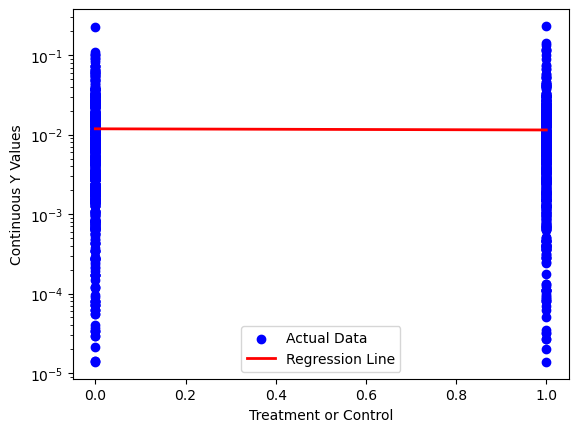

slope = -0.0003918741982523622


In [316]:
# Sample data
# treatment_control = np.array([0, 1, 0 ,1])  # 0 represents control, 1 represents treatment
# y_values = np.array([10, 20, 5, 15])  # Replace with your actual continuous y-values
treatment_control = matched_df['is_treated'].values
y_values = abs(matched_df['slope_change'].values)
print(f"")

# Reshape the data to meet the requirements of scikit-learn
X = treatment_control.reshape(-1, 1)
y = y_values.reshape(-1, 1)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Predict y-values based on the model
y_pred = model.predict(X)

# Plot the original data points
plt.scatter(treatment_control, y_values, color='blue', label='Actual Data')

# Plot the regression line
plt.plot(treatment_control, y_pred, color='red', linewidth=2, label='Regression Line')

# Add labels and legend
plt.xlabel('Treatment or Control')
plt.ylabel('Continuous Y Values')
plt.legend()
plt.yscale('log')

# Show the plot
plt.show()

slope = model.coef_[0, 0]
print(f"slope = {slope}")

In [317]:
name_by_movie_df

,char_words,order,gender,t_stat,p_value,slope_change
wiki_ID,,,,,,
3217,Gold,6.0,NaN,NaN,NaN,0.000000
3217,Linda,7.0,F,-0.416786,0.684853,0.000673
3217,Henry,4.0,M,-2.031668,0.067058,0.002513
3217,Duke,4.0,M,0.579441,0.573967,-0.000113
3217,Warrior,9.0,M,NaN,NaN,0.000000
...,...,...,...,...,...,...
37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130
37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365
37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603


In [ ]:
import pandas as pd
import os
from sklearn.neighbors import NearestNeighbors
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.express as px
import scipy.stats as st
import plotly.graph_objects as go

In [ ]:
folder_processed_data_path = './data/processed_data/'

# Import movie metadata
movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_df.csv'))
movie_df.set_index(['wiki_ID'], inplace=True)
display(movie_df)

# Import character metadata
name_by_movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_pvalue_10_5_df.csv'))
name_by_movie_df.set_index(['wiki_ID'], inplace=True)
display(name_by_movie_df)

# Dataset containing movie genre
movie_genres_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_genres_df.csv'))
movie_genres_df.set_index(['wiki_ID'], inplace=True)
display(movie_genres_df)

,mov_name,year,month,revenue,numVotes,averageRating
wiki_ID,,,,,,
975900,Ghosts of Mars,2001,8.0,14010832.0,56880,4.9
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,2.0,NaN,69,6.0
28463795,Brun bitter,1988,NaN,NaN,40,5.6
9363483,White Of The Eye,1987,NaN,NaN,2891,6.1
261236,A Woman in Flames,1983,NaN,NaN,623,5.9
...,...,...,...,...,...,...
35228177,Mermaids: The Body Found,2011,3.0,NaN,1711,4.6
34980460,Knuckle,2011,1.0,NaN,3192,6.8
9971909,Another Nice Mess,1972,9.0,NaN,111,5.8


,char_words,order,gender,t_stat,p_value,slope_change
wiki_ID,,,,,,
3217,Gold,6.0,NaN,NaN,NaN,0.000000
3217,Linda,7.0,F,-0.416786,0.684853,0.000673
3217,Henry,4.0,M,-2.031668,0.067058,0.002513
3217,Duke,4.0,M,0.579441,0.573967,-0.000113
3217,Warrior,9.0,M,NaN,NaN,0.000000
...,...,...,...,...,...,...
37478048,Ajay,9.0,M,-0.819213,0.430057,0.000130
37501922,Murphy,3.0,F,1.264175,0.232298,-0.000365
37501922,Hunter,1.0,M,-7.083089,0.000020,0.036603


,genre
wiki_ID,
330,Comedy-drama
330,Drama
3217,Action
3217,Comedy
3217,Time travel
...,...
37476824,Crime Comedy
37476824,Caper story
37476824,Crime Fiction


# Question 4 : Character importance in the film
In this section, we try to answer the question whether the importance of the character in the movie plays a role on the influence of baby names.

First, let's plot the number of character played in a year with significant impact with respect to the importance in movie.

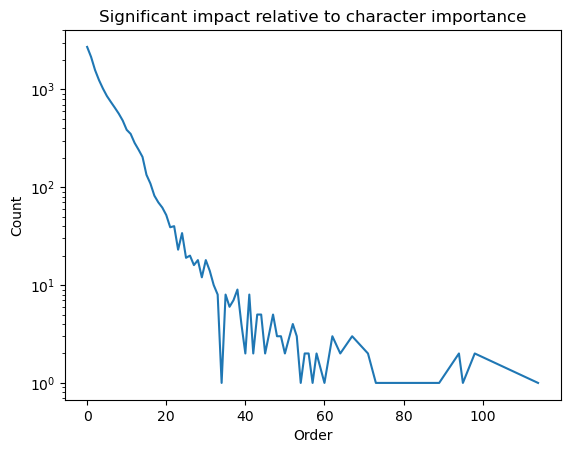

In [348]:
# count the number of significant characters per movie
signi_count_per_order = name_by_movie_df[name_by_movie_df['p_value'] <= 0.05].reset_index().groupby(['order'])['wiki_ID'].count().copy(deep=True)

# Create a line plot
plt.plot(signi_count_per_order.index, signi_count_per_order.values)

# Add labels and title
plt.xlabel('Order')
plt.ylabel('Count')
plt.title('Significant impact relative to character importance')
plt.yscale('log')

# Show the plot
plt.show()

We will consider only the first 15 order of importance.

In [349]:
# remove the rows with order higher than 15
name_by_movie_15_df = name_by_movie_df[name_by_movie_df['order'] <= 15].copy(deep=True)

Let's see the proportion of significant character to avoid being biased by the number of movies in each categories.

In [350]:
# compute the percentage of significant characters per order
signi_count_per_order = name_by_movie_15_df[name_by_movie_15_df['p_value'] <= 0.05].reset_index().groupby(['order'])['wiki_ID'].count().copy(deep=True)
count_per_order = name_by_movie_15_df.reset_index().groupby(['order'])['wiki_ID'].count().copy(deep=True)
percentage_per_order = (signi_count_per_order / count_per_order)*100
percentage_per_order = percentage_per_order.fillna(0)

# keep only the 15 first orders
percentage_per_order = percentage_per_order[:15]

In [351]:
# Plotting with Plotly
fig = px.bar(x=percentage_per_order.index, y=percentage_per_order.values,
             labels={'x': 'Order', 'y': 'Percentage of significant impact'},
             title='Character name impact per order',
             category_orders={'x': percentage_per_order.index})

# Set Y-axis range to highlight small differences
fig.update_layout(yaxis=dict(range=[9, 11.8]))

# Show the plot
fig.show()

Intesting, but let's see the proportion confidence intervals

In [352]:
# add a column in name_by_movie_15_df that contains a one if the variation is significant and zero otherwise
name_by_movie_15_df['is_significant'] = np.where(name_by_movie_15_df['p_value'] <= 0.05, 1, 0)

display(name_by_movie_15_df.sample(5))

,char_words,order,gender,t_stat,p_value,slope_change,is_significant
wiki_ID,,,,,,,
1518813,Etna,11.0,F,NaN,NaN,0.000000,0
32636880,Thomas,8.0,M,-6.102470,0.000077,0.016263,1
19468127,Jorge,8.0,M,1.015407,0.331726,-0.002211,0
793025,Phil,4.0,M,-0.381176,0.710332,0.000055,0
27091137,Chastity,11.0,F,-1.129180,0.282845,0.000210,0


In [353]:
def significant_proportion_and_ci(data):

    p = data['is_significant'].mean()
    se = np.sqrt(p * (1 - p) / len(data))

    # Compute confidence interval of 95%, using the mean and standard error
    ci_lower = p - 1.96 * se
    ci_upper = p + 1.96 * se

    # ************************ Alternative way to compute the standard error bis ************************
    # se = st.sem(data['is_significant'])
    # ci_lower = p - 1.96 * se
    # ci_upper = p + 1.96 * se
    # ************************ Alternative way to compute the standard error bis ************************

    # ************************ Alternative way to compute the standard error bis ************************
    # nb_significant = data['is_significant'].sum()
    # total = len(data)
    # (ci_lower, ci_upper) = sm.stats.proportion_confint(nb_significant, total, alpha=0.05)
    # ************************ Alternative way to compute the standard error bis ************************

    # Useful because we will put this in the dataframe
    return pd.Series({
        'mean': p,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

ci_df = name_by_movie_15_df.groupby(['order']).apply(significant_proportion_and_ci).reset_index()

In [354]:
# Plotting with Plotly
fig = px.bar(ci_df, x='order', y='mean',
             labels={'x': 'Order', 'y': 'Percentage of significant impact'},
             title='Character name impact per order',
             error_y='ci_upper',
             error_y_minus='ci_lower',)

# Show the plot
fig.show()

The intervals are far too large to deduce anything

## Study positive and negative variation

Among the character who played in a year with significant variation on the baby names, let's see the positive and negative variation's mean to compare.

In [355]:
name_by_movie_significant = name_by_movie_15_df[name_by_movie_15_df['is_significant'] == 1].copy(deep=True)

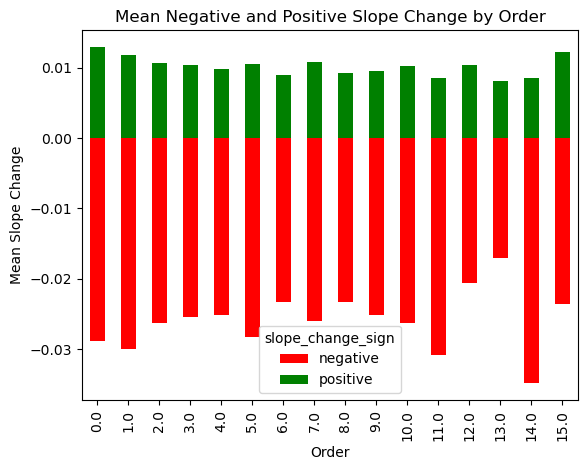

In [356]:
# Create a new column for positive and negative scores
name_by_movie_significant['slope_change_sign'] = name_by_movie_significant['slope_change'].apply(lambda x: 'negative' if x < 0 else 'positive')

# Group by 'order' and 'slope_change_sign', then calculate the mean
grouped_df = name_by_movie_significant.groupby(['order', 'slope_change_sign'])['slope_change'].mean().reset_index()

# Pivot the table for better plotting
pivot_df = grouped_df.pivot(index='order', columns='slope_change_sign', values='slope_change').reset_index()

# Plotting
pivot_df.plot(x='order', kind='bar', stacked=True, color=['red', 'green'])
plt.title('Mean Negative and Positive Slope Change by Order')
plt.xlabel('Order')
plt.ylabel('Mean Slope Change')
# plt.legend(['Mean negative slope change', 'Mean positive slope change'])
plt.show()

We see a higher mean variation for the negative variation, which suggests that the character with significant impact have a larger variation for negative than positive variations.

## Magnitude of the variation

We can express the magnitude of the variation by computing the difference of slop before and after the movie release. These differences are already available in the `name_by_movie` dataframe on the column `slope_change`. Let's plot the mean slope change for each order.

In [357]:
alpha = 0.05 # Significance level

name_by_movie_magnitude = name_by_movie_df.copy(deep=True)

# Keep only the significant characters
name_by_movie_magnitude = name_by_movie_magnitude[name_by_movie_magnitude['p_value'] <= alpha]

# Keep only the first 30 orders
name_by_movie_magnitude = name_by_movie_magnitude[name_by_movie_magnitude['order'] <= 20]

# Compute the absolute mean slope change
name_by_movie_magnitude['abs_slope_change'] = name_by_movie_magnitude['slope_change'].abs()
abs_mean_slope_change = name_by_movie_magnitude.groupby("order")['abs_slope_change'].mean()

# Compute the standard error of absolute slope change
abs_slope_change_se = name_by_movie_magnitude.groupby("order")['abs_slope_change'].sem()

# Create a dataframe with the mean and standard error
slope_change_mean_se_df = pd.DataFrame({'abs_mean_slope_change': abs_mean_slope_change, 'abs_slope_change_se': abs_slope_change_se})
display(slope_change_mean_se_df.sample(2))

,abs_mean_slope_change,abs_slope_change_se
order,,
3.0,0.014035,0.000593
10.0,0.013858,0.001229


In [358]:
# Création du bar chart interactif avec sous-graphiques
fig = go.Figure()

# Tracé pour avg magnitude slope change avec erreur
fig.add_trace(go.Bar(
    x=slope_change_mean_se_df.index,
    y=slope_change_mean_se_df['abs_mean_slope_change'],
    name='Avg Magnitude Slope Change',
    marker_color='orange',
    error_y=dict(
        type='data',
        array=slope_change_mean_se_df['abs_slope_change_se'],
        visible=True
    )
))

# Set the y-axis range
y_range = [0, 0.02]

# Mise en forme du tracé
fig.update_layout(
    xaxis=dict(title='Character Order'),
    yaxis=dict(title='Slope Change Magnitude', range=y_range),
    barmode='stack'
)

fig.show()